# Approximate Bayesian Computation

In [1]:
using Distributions, StatsPlots, Plots, StatsBase, LinearAlgebra
using LaTeXStrings
using SymPy
using VegaLite
using DataFrames
pyplot()

Plots.PyPlotBackend()

In [182]:
n, x = 8, 6
N = 1000

# Sample θ' from prior π(θ)
# Generate z from p(.|θ')
theta_s = rand(Beta(1,1),N)
z       = rand.(Binomial.(n,theta_s))
theta_a = theta_s[z .== x];
v = collect(range(0, stop=1, length=N));

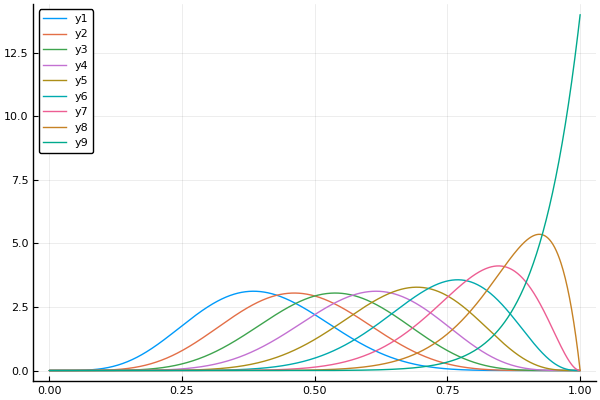

In [203]:
k = collect(0:1:n)
beta_distributions = pdf.(Beta.(x.+k',n .- k' .+1),v);
plot(v,beta_distributions)

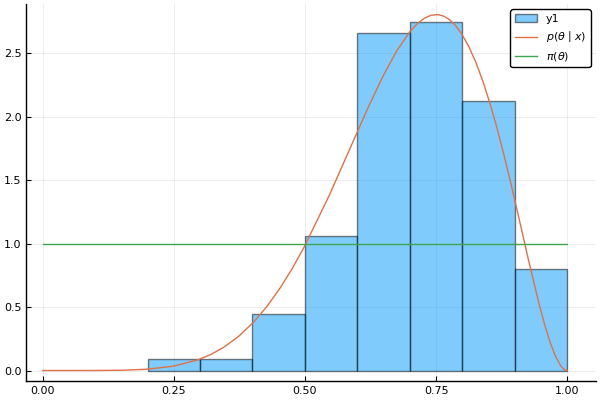

In [204]:
histogram(theta_a,normalize=true,alpha=0.5)
plot!(Beta(x+1,n-x+1),label=L"p(\theta \mid x)")
plot!(Beta(1,1), label =L"\pi(\theta)")

In [151]:
cm = countmap(z)
counter = zeros(length(cm))
hdots = zeros(N)
for (i,v) in enumerate(z)
    counter[v+1]+=1
    hdots[i] = counter[v+1]
end


df = DataFrame([z,hdots,theta_s,collect(1:length(z))]);

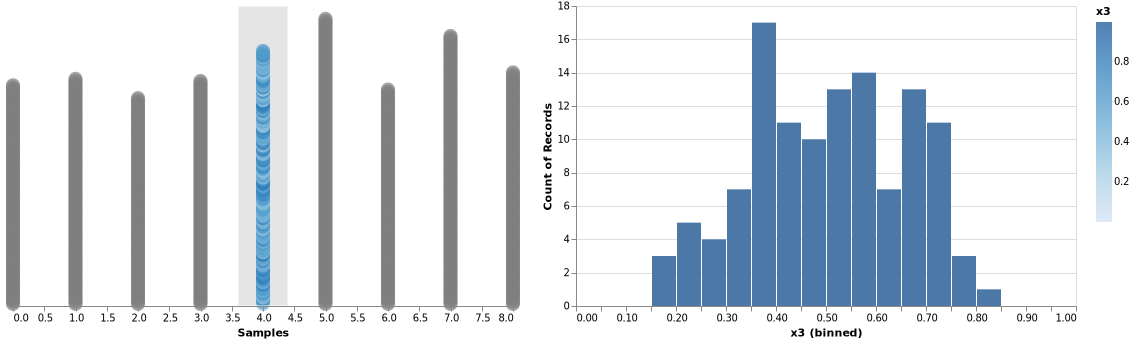

WARN Can not resolve event source: window
WARN Can not resolve event source: window
WARN Can not resolve event source: window
WARN Can not resolve event source: window


In [171]:
points = df |> vl"""
{
"hconcat" : [
  {
    "view":{"stroke" : null},
    "layer": [{

    
    "selection": {
      "brush": {"type": "interval","encodings": ["x"],"init":{"x": [3.6, 4.4]}}
    },
    "view":{"stroke" : null},
    "width": 500,
    "height": 300,
    "mark": "circle",
    "encoding": {
        "x": {"field": "x1", "type": "quantitative","axis": {"grid":false, "title":"Samples"}},
        "y": {"field": "x2", "type": "quantitative", "axis": null},
        "size":{"value":200},
        "color": {
              "condition": {"selection": "brush", "field": "x3", "type": "quantitative"},
              "value": "grey"
            }
        }
}]},
  {
    "layer":[{
    "transform": [
      {"filter": {"selection": "brush"}}
    ],
    "width": 500,
    "height": 300,
    "mark": "bar",
    "encoding": {
    "x": {
        "bin":{"maxbins":20},
        "field": "x3",
        "type": "quantitative"
    },
    "y": {
        "aggregate": "count",
        "type": "quantitative"
      }
    }}
    ]
}]
}
"""

In [138]:
hist = df |> vl"""{
  "mark": "bar",
  "encoding": {
    "x": {
      "bin": true,
      "field": "x3",
      "type": "quantitative"
    },
    "y": {
      "aggregate": "count",
      "type": "quantitative"
    }
  }
}"""
points = df |> vl"""
{
  "mark": "circle",
  "encoding": {
    "x": {"field": "x1", "type": "quantitative"},
    "y": {"field": "x2", "type": "quantitative"}
  }
}""";